## Exploratory Data Analysis

In [1]:
#Importing all the libraries I believe I will be using
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from library.sb_utils import save_file
from urllib.request import urlretrieve
from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
meta_df = pd.read_csv('SourceFiles/numerical_data.csv')

In [3]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6726 entries, 0 to 6725
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   metastasis            6726 non-null   int64
 1   tneg                  6726 non-null   int64
 2   invasive              6726 non-null   int64
 3   breast_chest_radi     6726 non-null   int64
 4   nodal_radi            6726 non-null   int64
 5   chemo                 6726 non-null   int64
 6   antihormone           6726 non-null   int64
 7   her2_inhib            6726 non-null   int64
 8   neo                   6726 non-null   int64
 9   er                    6726 non-null   int64
 10  pr                    6726 non-null   int64
 11  p53                   6726 non-null   int64
 12  her2                  6726 non-null   int64
 13  node_status           6726 non-null   int64
 14  age                   6726 non-null   int64
 15  menopause             6726 non-null   int64
 16  node_p

In [4]:
meta_df.head()

,metastasis,tneg,invasive,breast_chest_radi,nodal_radi,chemo,antihormone,her2_inhib,neo,er,...,tumor_duct,tumor_lobular,size,grade,surgery_no_residual,surgery_residual,no primary site,conservation_surgery,mastectomy_surgery,no_surgery
0,0,0,1,1,0,0,1,0,0,1,...,1,0,1,2,1,0,0,1,0,0
1,0,0,1,0,0,1,0,0,0,1,...,1,0,3,1,1,0,0,1,0,0
2,0,0,1,1,0,0,0,0,0,1,...,1,0,1,1,1,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,1,...,1,0,1,1,1,0,0,1,0,0
4,0,0,1,1,0,0,1,0,0,1,...,1,0,1,2,1,0,0,1,0,0


In [5]:
#Creating a data frame to store the counts of the metastasis in each element 
meta_df_counts = pd.DataFrame(index=[0,1])
#Creting the bar plot function
def barplots(columns, ncol=None, figsize=(10,35)):
    global meta_df_counts
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns)/ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize,squeeze=False)
    fig.subplots_adjust(wspace=0.6, hspace=0.4)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sub_df = meta_df[['metastasis',col]].groupby(['metastasis',col]).agg({'metastasis':'count'}).unstack()
        xlabel = col
        ylabel = ' % of patientes'
        sub_df.columns = [sub_df.columns.names[1]+'='+sub_df.columns[j][1].astype('str') for j in range(len(sub_df.columns))]
        meta_df_counts = pd.merge(meta_df_counts, sub_df, how='inner', left_index=True, right_index=True)
        sub_df.transpose().apply(lambda x: x*100/sum(x),axis=1).plot(kind="bar", stacked=True, ax=ax, rot=30)
        ax.set(xlabel=xlabel, ylabel=col + ylabel)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

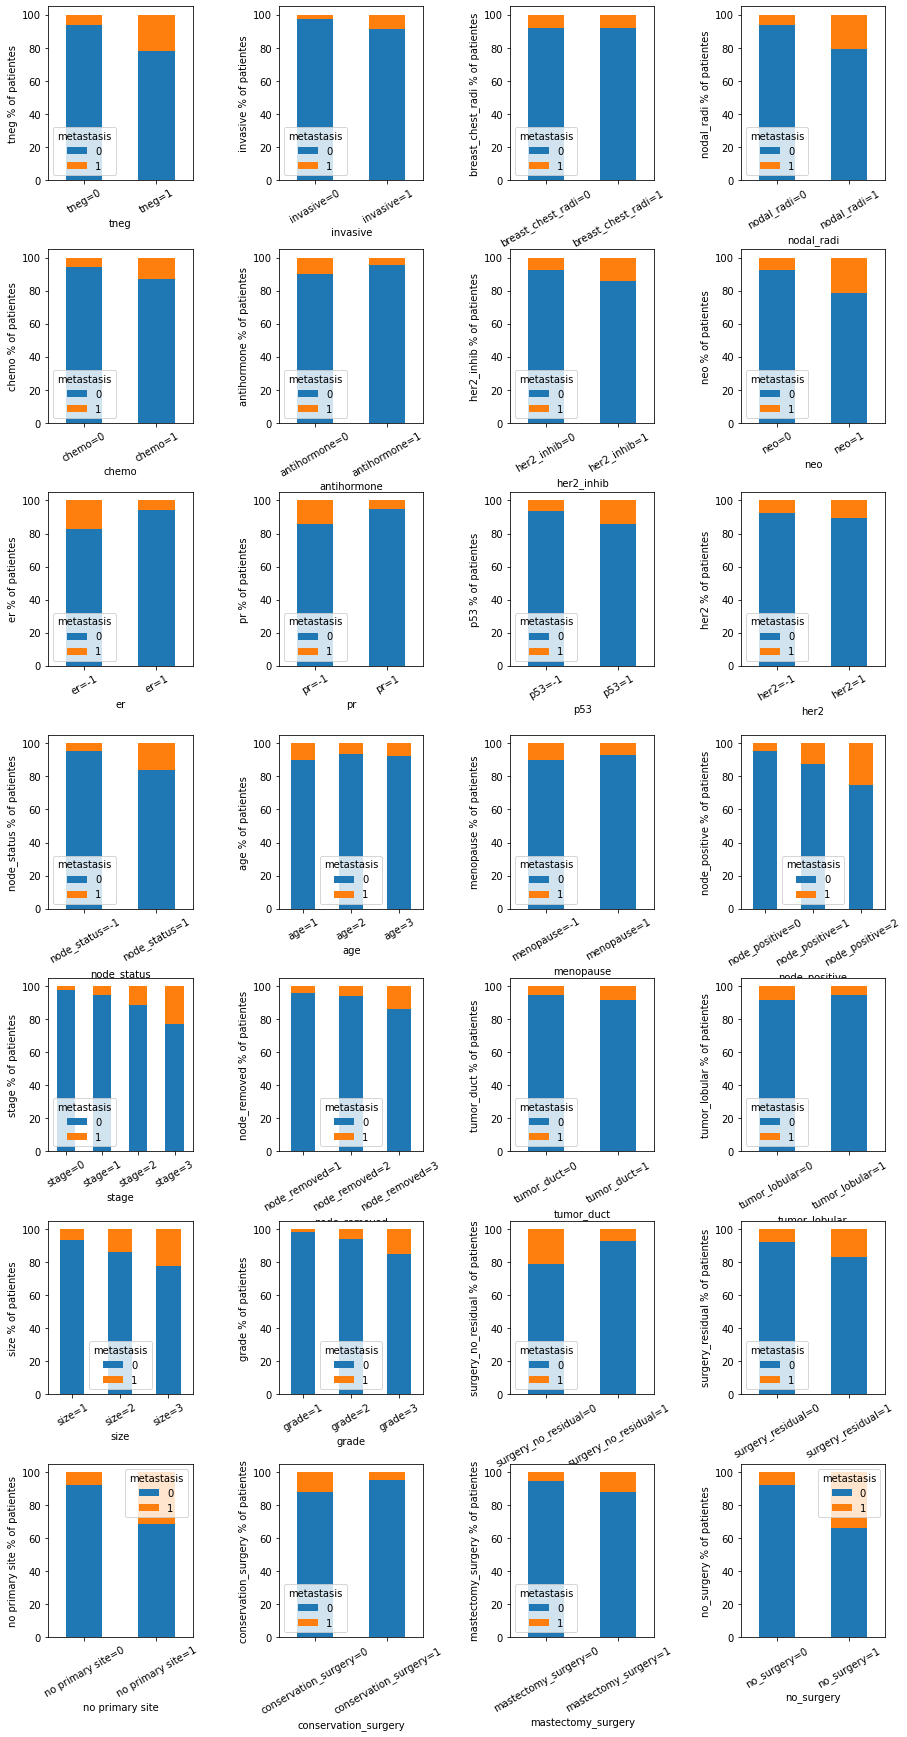

In [6]:
#The graphs where the blue and orange are very similar, are not too relevant to the analisys
barplots(meta_df.columns[1:],4, figsize=(15,30))

In [7]:
#The summary of this plot can be found in the new data frame
meta_df_counts.head()

,tneg=0,tneg=1,invasive=0,invasive=1,breast_chest_radi=0,breast_chest_radi=1,nodal_radi=0,nodal_radi=1,chemo=0,chemo=1,...,surgery_residual=0,surgery_residual=1,no primary site=0,no primary site=1,conservation_surgery=0,conservation_surgery=1,mastectomy_surgery=0,mastectomy_surgery=1,no_surgery=0,no_surgery=1
0,5635,558,981,5212,3056,3137,5553,640,4572,1621,...,6000,193,6126,67,2302,3891,3930,2263,6154,39
1,376,157,23,510,270,263,367,166,286,247,...,494,39,502,31,325,208,228,305,513,20


As shown in the plots above, not all the features affect the metastasis in the same level, proportion. Let's find out which one are relevant. In order to accomplish this, we will make our null hypothesis.

**H0**: There is no relationship between a single feature and the metastasis outcome.

In [8]:
single_names = [name.split('=')[0] for name in meta_df_counts.columns]
for i in range(2):
    single_names.remove('tumor_duct')
    single_names.remove('tumor_lobular')
    single_names.remove('surgery_no_residual')
    single_names.remove('surgery_residual')
    single_names.remove('no primary site')
    single_names.remove('conservation_surgery')
    single_names.remove('mastectomy_surgery')
    single_names.remove('no_surgery')

single_names = np.sort(np.unique(single_names))
single_names = single_names[::-1]
print(single_names)

['tneg' 'stage' 'size' 'pr' 'p53' 'node_status' 'node_removed'
 'node_positive' 'nodal_radi' 'neo' 'menopause' 'invasive' 'her2_inhib'
 'her2' 'grade' 'er' 'chemo' 'breast_chest_radi' 'antihormone' 'age']


In [9]:
import scipy.stats as stats
#this includes the chi2_contingency

In [10]:
def getfeature_df(col):
    selected_names = [x for x in meta_df_counts.columns if x.startswith(col)]
    return meta_df_counts[selected_names].T

#Example of what this fucntion returns
getfeature_df('age')

,0,1
age=1,1881,210
age=2,2603,184
age=3,1709,139


In [11]:
#Calculating chi2 for columns not splitted
chi2_df = pd.DataFrame(columns=['feature','chi2','p-val','dof'])
for i, col in enumerate(single_names):
    sub_df = getfeature_df(col)
    chi2, p, dof, expected = stats.chi2_contingency(sub_df)
    chi2_df.loc[i] = [col,chi2,p,dof]
    
#Calculating chi2 for columns splitted in the data wrangling section
sub_df = pd.concat([getfeature_df('tumor_duct=1'),getfeature_df('tumor_lobular=1')])
chi2, p, dof, expected = stats.chi2_contingency(sub_df)
chi2_df.loc[i+1] = ['histology',chi2,p,dof]

sub_df = pd.concat([getfeature_df('surgery_no_residual=1'),getfeature_df('surgery_residual=1'),getfeature_df('no primary site=1')])
chi2, p, dof, expected = stats.chi2_contingency(sub_df)
chi2_df.loc[i+2] = ['surgical_margins',chi2,p,dof]

sub_df = pd.concat([getfeature_df('conservation_surgery=1'),getfeature_df('mastectomy_surgery=1'),getfeature_df('no_surgery=1')])
chi2, p, dof, expected = stats.chi2_contingency(sub_df)
chi2_df.loc[i+3] = ['surgery',chi2,p,dof]

In [12]:
chi2_df.sort_values(by='p-val',inplace=True, ascending=True)
chi2_df.reset_index(inplace=True, drop=True)
chi2_df.set_index('feature',inplace=True)
chi2_df

,chi2,p-val,dof
feature,,,
node_positive,353.109702,2.104759e-77,2
stage,344.057017,2.887221e-74,3
node_status,261.217355,9.314600e-59,1
grade,247.728400,1.608650e-54,2
tneg,213.795658,2.040775e-48,1
nodal_radi,199.534848,2.638391e-45,1
er,193.341500,5.929067e-44,1
node_removed,171.185182,6.723727e-38,2
pr,151.234017,9.316227e-35,1


As we can see, we will reject the null hypothesis for all the features where the p-value is less than 0.05, since those categories don't show an statistical significance. The only null hypotesis we will accept is that the breast or chest radiation is not significance to the metastasis.

Let's plot the features to see which ones (in percentage), contribute more for the metastasis, since, the larger the Chi-square value, the greater the probability that there really is a significant difference between the feature and metastasis.  

In [13]:
chi2_df['chi2'].shape[0]

23

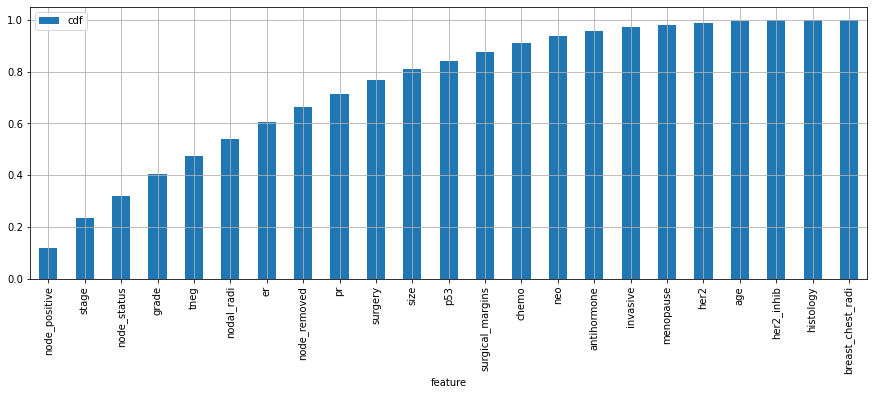

In [14]:
chi2_df['cdf'] = chi2_df['chi2'].cumsum() / chi2_df['chi2'].sum()
chi2_df.plot.bar(y = 'cdf', grid=True, figsize=(15,5))
plt.show()